In this notebook, I analyze a dataset of house prices, create a deliverable containing different important visualizations of the data and build a predictive model of house prices. The data was all created, not collected from a real population.

In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import statsmodels.formula.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder#, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline

In [2]:
dataset=pd.read_csv(os.path.join(os.getcwd(), "house_data.csv"))

### Data inspection and visualization

In [3]:
dataset.shape

(21613, 21)

In [4]:
dataset.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
dataset.isnull().any().any()

False

No missing data

In [6]:
pd.options.display.max_columns = dataset.shape[1]
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


I imagine the most import features are number of bedrooms, bathrooms, yr_renovated and zipcode. Some variables may show collinearity, so we have to check for this.

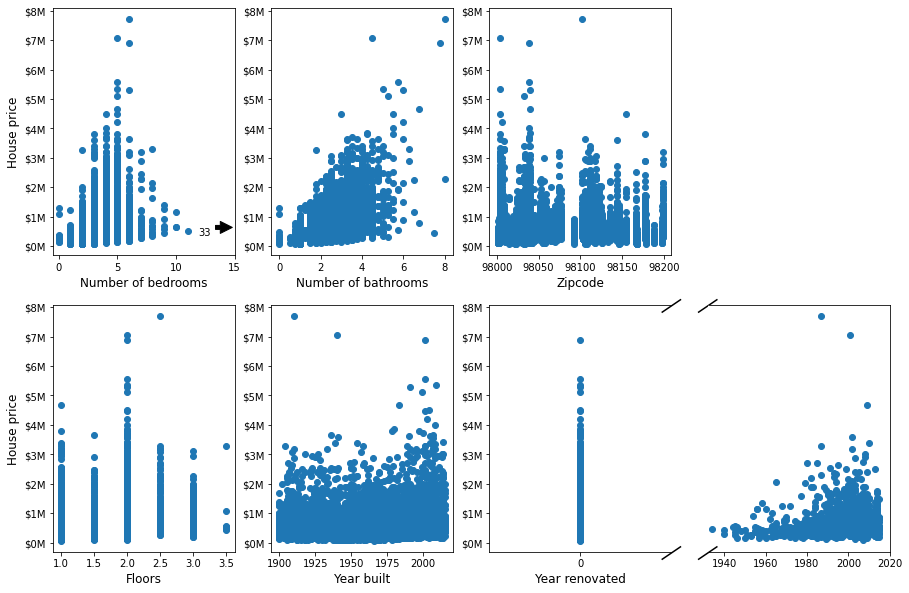

In [7]:
plt.close('all')

plt.figure(figsize=(15,10))

gs = gridspec.GridSpec(2, 4)
axsa = plt.subplot(gs[0, 0])
axsb = plt.subplot(gs[0, 1])
axsc = plt.subplot(gs[0, 2])
axsd = plt.subplot(gs[1, 0])
axse = plt.subplot(gs[1, 1])
axsf = plt.subplot(gs[1, 2])
axsg = plt.subplot(gs[1, 3])


def y_tick_format(x, pos):
    return f'${x / 1e6:1.0f}M'

axsa.scatter(dataset['bedrooms'], dataset['price'])
axsa.set_xlabel('Number of bedrooms', fontsize=12)
axsa.set_ylabel('House price', fontsize=12)
axsa.set_xlim(-0.5,15)
axsa.yaxis.set_major_formatter(y_tick_format)
axsa.grid(False)

axsa.set_xlim(-0.5,15)
# arrow for indicating outlier
axsa.annotate('33',
            xy=(15, dataset['price'][dataset['bedrooms'] > 15]),
            xycoords='data',
            xytext=(13, dataset['price'][dataset['bedrooms'] > 15]), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.1),
            horizontalalignment='right', verticalalignment='top')


axsb.scatter(dataset['bathrooms'], dataset['price'])
axsb.set_xlabel('Number of bathrooms', fontsize=12)
axsb.yaxis.set_major_formatter(y_tick_format)
axsb.grid(False)

axsc.scatter(dataset['zipcode'], dataset['price'])
axsc.set_xlabel('Zipcode', fontsize=12)
axsc.yaxis.set_major_formatter(y_tick_format)
axsc.grid(False)

axsd.scatter(dataset['floors'], dataset['price'])
axsd.set_xlabel('Floors', fontsize=12)
axsd.set_ylabel('House price', fontsize=12)
axsd.yaxis.set_major_formatter(y_tick_format)
axsd.grid(False)

axse.scatter(dataset['yr_built'], dataset['price'])
axse.set_xlabel('Year built', fontsize=12)
axse.yaxis.set_major_formatter(y_tick_format)
axse.grid(False)

kwargs = dict(transform=axsa.transAxes, color='k', clip_on=False)

axsf.scatter(dataset['yr_renovated'], dataset['price']), axsg.scatter(dataset['yr_renovated'], dataset['price'])
axsf.set_xlabel('Year renovated', fontsize=12)
axsf.set_xlim(-0.1, 0.1), axsg.set_xlim(1932, 2020) 
axsf.set_xticks([0])
axsf.yaxis.set_major_formatter(y_tick_format)
axsf.grid(False)
axsf.spines['right'].set_visible(False)
axsg.spines['left'].set_visible(False)
axsg.tick_params(left=False, labelleft=False) # don't put tick labels at the top

axsf.plot((3.55,3.65),(-.23,-.18), **kwargs), axsf.plot((3.35,3.45),(-.23,-.18), **kwargs), kwargs.update(transform=axsb.transAxes)
axsg.plot((2.15,2.25),(-1.23,-1.18), **kwargs), axsg.plot((2.35,2.45),(-1.23,-1.18), **kwargs), kwargs.update(transform=axsb.transAxes)

save_obj = os.path.join(os.getcwd(), 'scatterplots.png')
plt.savefig(save_obj, dpi = 200)

<!-- <img src="scatterplots.png" width="400"/> -->

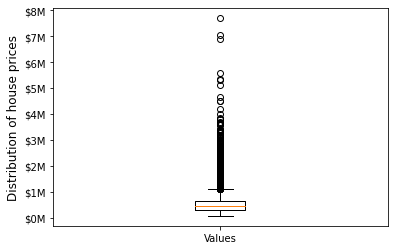

In [8]:
plt.close('all')

fig, axs = plt.subplots(1, 1)
axs.boxplot(dataset['price'])
axs.set_ylabel('Distribution of house prices', fontsize=12)
axs.yaxis.set_major_formatter(y_tick_format)
axs.xaxis.set_major_formatter('Values')
plt.show()

There is a record with high leverage (bedrooms > 30) and also outliers.

Checking for collinearity in predictor variables

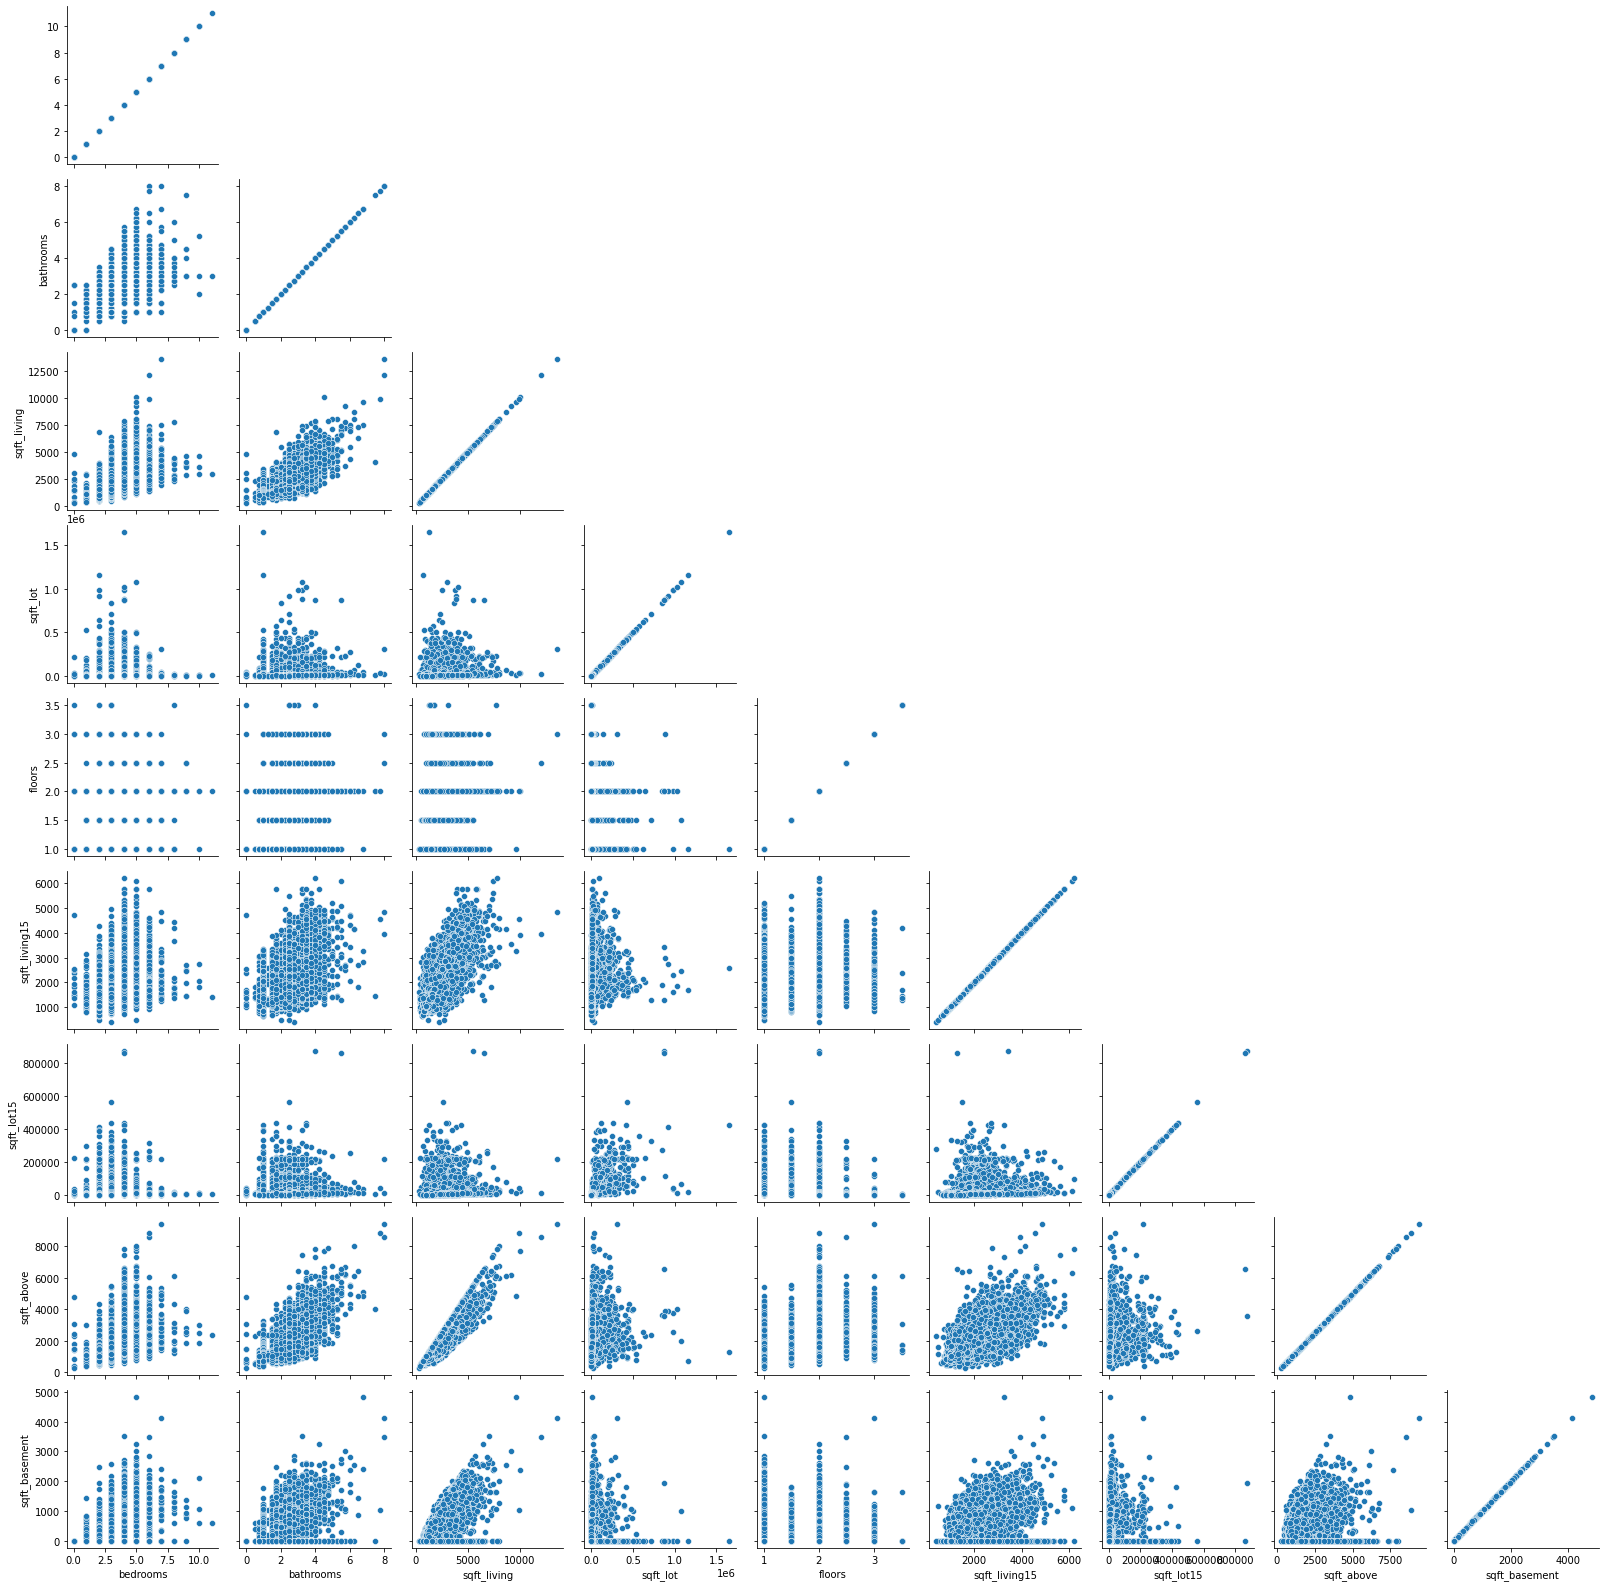

In [9]:
plt.close('all')
scatter_matrix = sns.PairGrid(dataset.drop(dataset[dataset['bedrooms']>15].index).loc[:, [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_living15', 'sqft_lot15', 
    'sqft_above', 'sqft_basement']],
                              corner=True)
scatter_matrix.map(sns.scatterplot)

Many variables are correlated. Most uncorrelated variables seem to be bedrooms, sqft_lot, floors

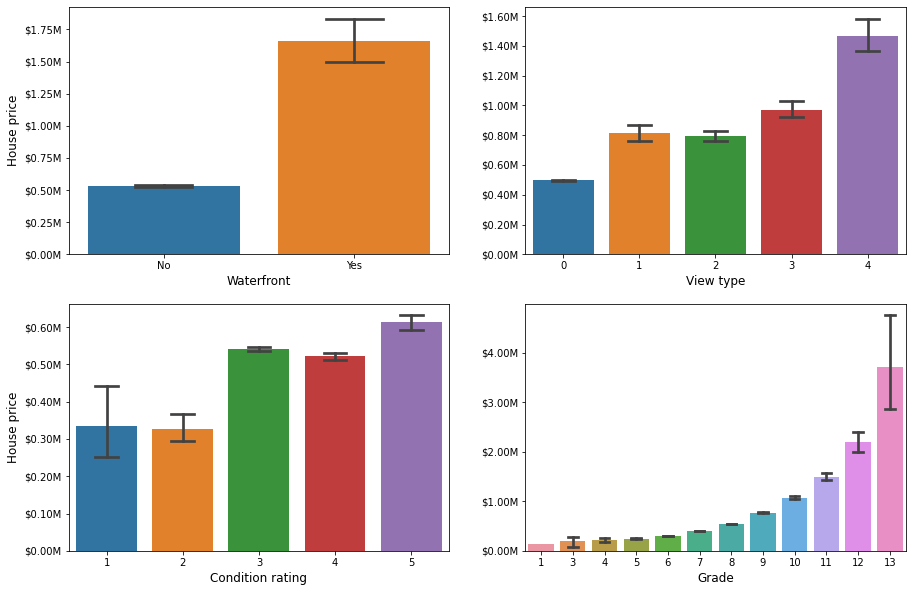

In [10]:
plt.close('all')

fig, axs = plt.subplots(2, 2)

fig.set_size_inches(15, 10)

def y_tick_format(x, pos, rounding=2):
    return f'${x / 1e6:2.2f}M'

plot1=sns.barplot(ax=axs[0,0], x=dataset['waterfront'], y=dataset['price'], data=dataset, seed=1234, capsize=0.3)
plot1.set_xlabel('Waterfront', fontsize=12)
plot1.yaxis.set_major_formatter(y_tick_format)
plot1.set_xticklabels(['No', 'Yes'])
plot1.set_ylabel('House price', fontsize=12)

plot2=sns.barplot(ax=axs[0,1],x=dataset['view'], y=dataset['price'], data=dataset, seed=1234, capsize=0.3)
plot2.set_xlabel('View type', fontsize=12)
plot2.yaxis.set_major_formatter(y_tick_format)
plot2.set_ylabel('', fontsize=12)

plot3=sns.barplot(ax=axs[1,0],x=dataset['condition'], y=dataset['price'], data=dataset, seed=1234, capsize=0.3)
plot3.set_xlabel('Condition rating', fontsize=12)
plot3.yaxis.set_major_formatter(y_tick_format)
plot3.set_ylabel('House price', fontsize=12)

plot4=sns.barplot(ax=axs[1,1],x=dataset['grade'], y=dataset['price'], data=dataset, seed=1234, capsize=0.3)
plot4.set_xlabel('Grade', fontsize=12)
plot4.yaxis.set_major_formatter(y_tick_format)
plot4.set_ylabel('', fontsize=12)

save_obj = os.path.join(os.getcwd(), 'barplots.png')
plt.savefig(save_obj, dpi = 200)

Generating a deliverable document

In [11]:
!pandoc report.md -s -o house-prices-report.pdf -V geometry:margin=1in

### Building a predictive model

Since I will perform cross-validation, I will not split the data into a training and a validation set.

In [12]:
# separating target from predictors and splitting in training and validation sets
y = dataset.price
X = dataset.drop(['price'], axis=1)

One-Hot Encoding categorical variables

In [13]:
object_cols=['waterfront', 'view', 'zipcode', 'floors']
numerical_cols=X.columns.difference(object_cols)

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
OHE_cols_X = pd.DataFrame(ohe.fit_transform(X[object_cols]))

# One-hot encoding removed index; put it back
OHE_cols_X.index = X.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = X.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OHE_X = pd.concat([num_X, OHE_cols_X], axis=1)

# Also dropping id, date, lat and long because I'm not going to use these variables
OHE_X.drop(['date', 'id', 'lat', 'long'], axis=1, inplace = True)

#### Linear regression

Using a linear model since it is the easiest to interpret.

In [14]:
lm = LinearRegression()

def adj_r2(data, r2, folds):
    """Adjusted R squared"""
    return 1-(1-r2)*((data.shape[0] / folds) -1)/((data.shape[0] / folds) - (data.shape[1] / folds)-1)

First, a full model

In [15]:
scores = cross_validate(lm, OHE_X, y,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

mean_rmse=np.mean(scores['test_neg_root_mean_squared_error']) * -1
mean_adj_r2=np.mean(adj_r2(OHE_X, scores['test_r2'], 5))
print(f'Test mean RMSE = {mean_rmse:3,.2f}\n'
      f'Test mean Adjusted R² = {mean_adj_r2:3,.2f}\n')

Test mean RMSE = 161,410.95
Test mean Adjusted R² = 0.81



Removing correlated features:

In [16]:
OHE_X_no_corr = OHE_X.drop(['sqft_living15', 'sqft_lot15', 'sqft_lot', 'sqft_above', 'sqft_basement', 'bathrooms'], axis=1)
scores = cross_validate(lm, OHE_X_no_corr, y,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

mean_rmse=np.mean(scores['test_neg_root_mean_squared_error']) * -1
mean_adj_r2=np.mean(adj_r2(OHE_X, scores['test_r2'], 5))
print(f'Test mean RMSE = {mean_rmse:3,.2f}\n'
      f'Test mean Adjusted R² = {mean_adj_r2:3,.2f}\n')

Test mean RMSE = 163,635.83
Test mean Adjusted R² = 0.80



A little lower validation score compared to previous model, but still worth it, I think

In [17]:
y_pred = cross_val_predict(lm, OHE_X_no_corr, y)
(y_pred < 0).any()

True

A problem with this model is that it predicts negative prices

The cell below runs a model without outliers and the high leverage point

In [18]:
lof = LocalOutlierFactor()
outliers = lof.fit_predict(OHE_X_no_corr)
rows_to_keep = outliers != -1
X_nooutlier, y_nooutlier = OHE_X_no_corr[rows_to_keep], y[rows_to_keep]
high_leverage_index=X_nooutlier[X_nooutlier['bedrooms']==33].index
X_nooutlier=X_nooutlier.drop(high_leverage_index)
y_nooutlier=y_nooutlier.drop(high_leverage_index)

lm.fit(X_nooutlier, y_nooutlier)
scores = cross_validate(lm, X_nooutlier, y_nooutlier,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

mean_rmse=np.mean(scores['test_neg_root_mean_squared_error']) * -1
mean_adj_r2=np.mean(adj_r2(X_nooutlier, scores['test_r2'], 5))
print(f'Test mean RMSE = {mean_rmse:3,.2f}\n'
      f'Test mean Adjusted R² = {mean_adj_r2:3,.2f}\n')

Test mean RMSE = 152,620.01
Test mean Adjusted R² = 0.80



Removing these records makes a reasonable difference

##### Diagnostic plots using statsmodels

In [19]:
# statsmodels does one-hot encoding by itself, so we use the numerical variables from X
X_nooutlier, y_nooutlier = X[rows_to_keep], y[rows_to_keep]
high_leverage_index=X_nooutlier[X_nooutlier['bedrooms']==33].index
X_nooutlier=X_nooutlier.drop(high_leverage_index)
y_nooutlier=y_nooutlier.drop(high_leverage_index)

lmdata=pd.concat([y_nooutlier, X_nooutlier], axis=1).drop(['sqft_living15', 'sqft_lot15', 'sqft_lot', 'sqft_above', 'sqft_basement',
                                                   'bathrooms', 'id', 'date', 'lat', 'long'], axis=1)
# transforming categorical variables to obj
lmdata[object_cols[0]]=lmdata[object_cols[0]].apply(str)
lmdata[object_cols[1]]=lmdata[object_cols[1]].apply(str)
lmdata[object_cols[2]]=lmdata[object_cols[2]].apply(str)
lmdata[object_cols[3]]=lmdata[object_cols[3]].apply(str)

In [20]:
formula_str = lmdata.columns[0]+' ~ '+'+'.join(lmdata.drop(['price'],axis=1).columns)

model=sm.ols(formula=formula_str, data=lmdata)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:08:55   Log-Likelihood:            -2.8646e+05
No. Observations:               21464   AIC:                         5.731e+05
Df Residuals:                   21378   BIC:                         5.738e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          7.03e+05   1.21e+05  

The model seems to be very inflated due to the numerous zipcode variables. Let's drop this variable and see what happens

In [21]:
formula_str = lmdata.columns[0]+' ~ '+'+'.join(lmdata.drop(['price', 'zipcode'],axis=1).columns)

model=sm.ols(formula=formula_str, data=lmdata)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     2457.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:08:55   Log-Likelihood:            -2.9311e+05
No. Observations:               21464   AIC:                         5.863e+05
Df Residuals:                   21447   BIC:                         5.864e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.354e+06   1.39e+05     

Lower $R^2$, but I still think this model makes more sense, because zipcode doesn't seem to have a linear relationship with price, as the scatter plots above show

Now diagnosing the model for normality and variance heteroscedasticity

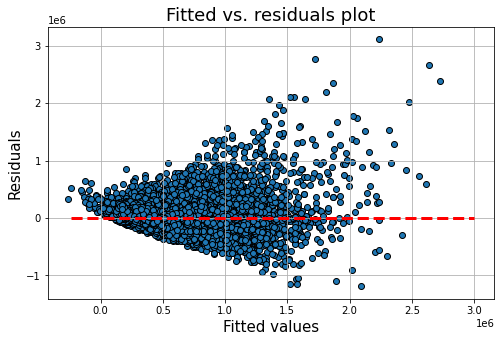

In [22]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

<Figure size 576x360 with 0 Axes>

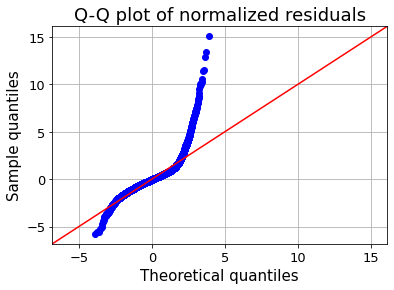

In [23]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

Strong heteroscedasticity and deviation from normality. Let's try to fix this by log-transforming the target variable

In [24]:
lmdata['pricelog10']=np.log(lmdata['price'])
formula_str = lmdata.columns[-1]+' ~ '+'+'.join(lmdata.drop(['price', 'pricelog10', 'zipcode'],axis=1).columns)

model=sm.ols(formula=formula_str, data=lmdata)
fitted = model.fit()

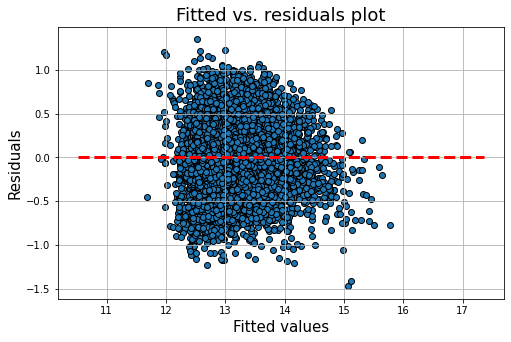

In [25]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

<Figure size 576x360 with 0 Axes>

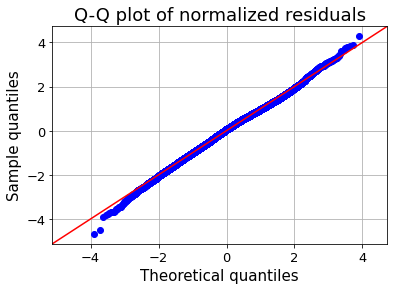

In [26]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

This model is much more adequate, and we also get rid of negative fitted values. Now let's see what we can learn from it.

In [27]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:             pricelog10   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2332.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:08:56   Log-Likelihood:                -5604.4
No. Observations:               21464   AIC:                         1.124e+04
Df Residuals:                   21447   BIC:                         1.138e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          20.1844      0.212     

All variables are important to the model. By looking at the coefficients, we can see that the ones that most influence price are waterfront, grade and floors. This is in line with the barplots from above.

In [28]:
new_X=lmdata.drop(['price', 'pricelog10', 'zipcode'], axis=1)
object_cols=['waterfront', 'view', 'floors']
numerical_cols=new_X.columns.difference(object_cols)

ohe = OneHotEncoder(handle_unknown='error', sparse=False)
OHE_cols_X = pd.DataFrame(ohe.fit_transform(new_X[object_cols]))

# One-hot encoding removed index; put it back
OHE_cols_X.index = new_X.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = new_X.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
new_X = pd.concat([num_X, OHE_cols_X], axis=1)

In [29]:
lm.fit(new_X, np.log(y_nooutlier))
scores = cross_validate(lm, new_X, y_nooutlier,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

mean_rmse=np.mean(scores['test_neg_root_mean_squared_error']) * -1
mean_adj_r2=np.mean(adj_r2(new_X, scores['test_r2'], 5))
print(f'Test mean RMSE = {mean_rmse:3,.2f}\n'
      f'Test mean Adjusted R² = {mean_adj_r2:3,.2f}\n')

train_mean_rmse=np.mean(scores['train_neg_root_mean_squared_error']) * -1
train_mean_adj_r2=np.mean(adj_r2(new_X, scores['train_r2'], 5))
print(f'Train mean RMSE = {train_mean_rmse:3,.2f}\n'
      f'Train mean Adjusted R² = {train_mean_adj_r2:3,.2f}\n')

Test mean RMSE = 207,053.31
Test mean Adjusted R² = 0.64

Train mean RMSE = 206,152.23
Train mean Adjusted R² = 0.65



Dropping zipcode does make the RMSE rise significantly. There is no evidence of overfitting, as we see by comparing the validation and train RMSEs.

#### Boosted trees

Lastly, we can check if a boosted trees model can improve prediction performance compared to the linear model (I expect it will do so)

In [30]:
xgb_reg = xgb.XGBRegressor(random_state=1234, tree_method='hist')
pipe = Pipeline(steps=[('xgb', xgb_reg)])
param_grid = {
    'xgb__n_estimators': [1000, 2000, 3000, 4000],
    'xgb__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'xgb__max_depth': [1, 3, 5, 7, 9]
}

search = GridSearchCV(pipe, param_grid, scoring=('r2', 'neg_root_mean_squared_error'), return_train_score=True, refit='neg_root_mean_squared_error')
time1 = time.time()
search.fit(OHE_X, y)
time2 = time.time()
print(f'Execution time={time2-time1}')
print(f'Best hyperparameters={search.best_params_}\n')

Execution time=2691.580764055252
Best hyperparameters={'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 4000}



In [31]:
mean_rmse=search.best_score_ * -1
mean_adj_r2=adj_r2(OHE_X, search.cv_results_['mean_test_r2'], 1)
print(f'Test mean RMSE = {mean_rmse:3,.2f}\n'
      f'Test mean Adjusted R² = {mean_adj_r2[0]:3,.2f}\n')

train_mean_rmse=np.mean(search.cv_results_['mean_train_neg_root_mean_squared_error'] * -1)
train_mean_adj_r2=np.mean(adj_r2(OHE_X, search.cv_results_['mean_train_r2'], 1))
print(f'Train mean RMSE = {train_mean_rmse:3,.2f}\n'
      f'Train mean Adjusted R² = {train_mean_adj_r2:3,.2f}\n')

Test mean RMSE = 128,691.01
Test mean Adjusted R² = 0.79

Train mean RMSE = 54,569.66
Train mean Adjusted R² = 0.96



Lower test RMSE than linear model. Since the test RMSE is greater than the train RMSE, the model may be overfitting. We have to keep this in mind, but, of course, this is some evidence of overfitting, not concrete proof of it.

In [32]:
(search.predict(OHE_X) < 0).any()

False

No negative predicted values

Analyzing model performance

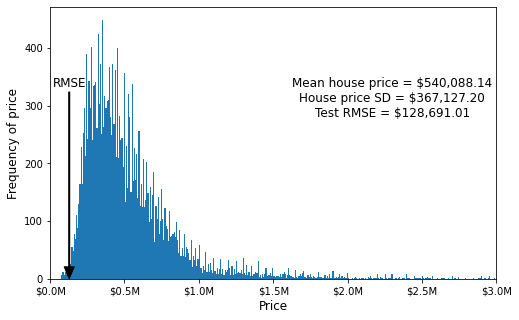

In [33]:
def y_tick_format(x, pos):
    return f'${x / 1e6:3.1f}M'

plt.close('all')

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8, 5)

axs.hist(y, bins=1000)
# reducing x range to aid in visualization
axs.set_xlim(0,3*10**6)
axs.set_ylabel('Frequency of price', fontsize=12)
axs.set_xlabel('Price', fontsize=12)
axs.xaxis.set_major_formatter(y_tick_format)

axs.annotate(f'RMSE',
            xytext=(mean_rmse, 350),
            xycoords='data',
            xy=(mean_rmse, 0), textcoords='data',
            arrowprops=dict(facecolor='black', width=1, headwidth=10),
            horizontalalignment='center', verticalalignment='top', fontsize=12)

axs.annotate(f'Mean house price = ${y.mean():3,.2f}\n'
      f'House price SD = ${y.std():3,.2f}\n'
      f'Test RMSE = ${mean_rmse:3,.2f}',
            xytext=(2.5*10**6 - 200000, 350),
            xycoords='data',
            xy=(mean_rmse, 0), textcoords='data',
            horizontalalignment='center', verticalalignment='top', fontsize=12)

plt.show()

Conclusion: as expected, boosted trees performed better than linear regression, with a RMSE of \$128,691. I consider this metric to be good, since it is almost 5 times lower than the mean of the target variable and it is also less than half the SD of the target variable. Although interpreting a linear model is much easier, this model has two other important advantages over the other: it decorrelates variables (since it is an ensemble of trees), and produces no negatives predictions. I would choose this model for production.